# 📊 Fetching Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip "/content/drive/MyDrive/AP/first_video.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/labels/frame_10348.txt  
  inflating: train/labels/frame_22732.txt  
  inflating: train/labels/frame_4966.txt  
  inflating: train/labels/frame_10006.txt  
  inflating: train/labels/frame_3726.txt  
  inflating: train/labels/frame_10802.txt  
  inflating: train/labels/frame_19552.txt  
  inflating: train/labels/frame_8994.txt  
  inflating: train/labels/frame_4010.txt  
  inflating: train/labels/frame_990.txt  
  inflating: train/labels/frame_19012.txt  
  inflating: train/labels/frame_17020.txt  
  inflating: train/labels/frame_19902.txt  
  inflating: train/labels/frame_4144.txt  
  inflating: train/labels/frame_1742.txt  
  inflating: train/labels/frame_16608.txt  
  inflating: train/labels/frame_5596.txt  
  inflating: train/labels/frame_4194.txt  
  inflating: train/labels/frame_4398.txt  
  inflating: train/labels/frame_10234.txt  
  inflating: train/labels/frame_18130.txt  
  inflating: train/labels/frame_1322

# 👩🏿‍🔧 Installations

Note: after installation is complete (it make take a few minutes), you'll need to restart the runtime after installation completes.

In [ ]:
%%capture
!pip install super-gradients==3.1.3

In [ ]:
!pip install torch
!pip install imutils
!pip install Pillow
!pip install deep-sort-realtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 45.6 MB/s eta 0:00:00


# 🏗️ Imports

In [ ]:
import os

import requests
import torch
from PIL import Image

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val
)
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)

The console stream is logged into /root/sg_logs/console.log


[2023-10-17 19:56:04] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-10-17 19:56:19] INFO - utils.py - NumExpr defaulting to 2 threads.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-10-17 19:56:23] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-10-17 19:56:23] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-10-17 19:56:23] WARNING - export.py - Failed to import pytorch_quantization
[2023-10-17 19:56:23] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


# 🗃️ Config

This class will store variables that will be used throughout the notebook

In [ ]:
class config:
    #trainer params
    CHECKPOINT_DIR = '/content/drive/MyDrive/AP/checkpoints' #specify the path you want to save checkpoints to
    EXPERIMENT_NAME = 'first_video_yolonas_run' #specify the experiment name

    #dataset params
    DATA_DIR = '/content/' #parent directory to where data lives

    TRAIN_IMAGES_DIR = '/content/train/images' #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = '/content/train/labels' #child dir of DATA_DIR where train labels are

    VAL_IMAGES_DIR = '/content/validation/images' #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR = '/content/validation/labels' #child dir of DATA_DIR where validation labels are

    # if you have a test set
    TEST_IMAGES_DIR = '/content/test/images' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = '/content/test/labels' #child dir of DATA_DIR where test labels are

    #what class names do you have
    CLASSES = ['0','car', 'person', 'bicycle', 'trailer','motorcycle','truck','bus', 'scooter', 'train', 'animal', 'bicycle_rack','movable_object']

    NUM_CLASSES = len(CLASSES)

    #dataloader params - you can add whatever PyTorch dataloader params you have
    #could be different across train, val, and test
    DATALOADER_PARAMS={
    'batch_size':4,
    'num_workers':8
    }

    # model params
    MODEL_NAME = 'yolo_nas_s' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' #only one option here: coco


# 🏋🏽 The Trainer

In [ ]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

# 💾 Datasets and Dataloaders


In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

Caching annotations: 100%|██████████| 9925/9925 [00:04<00:00, 2153.31it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Caching annotations:  54%|█████▎    | 667/1242 [00:00<00:00, 2202.09it/s]

## 👀 See what some images look like after augmentations

Caching annotations: 100%|██████████| 1242/1242 [00:00<00:00, 2146.67it/s]


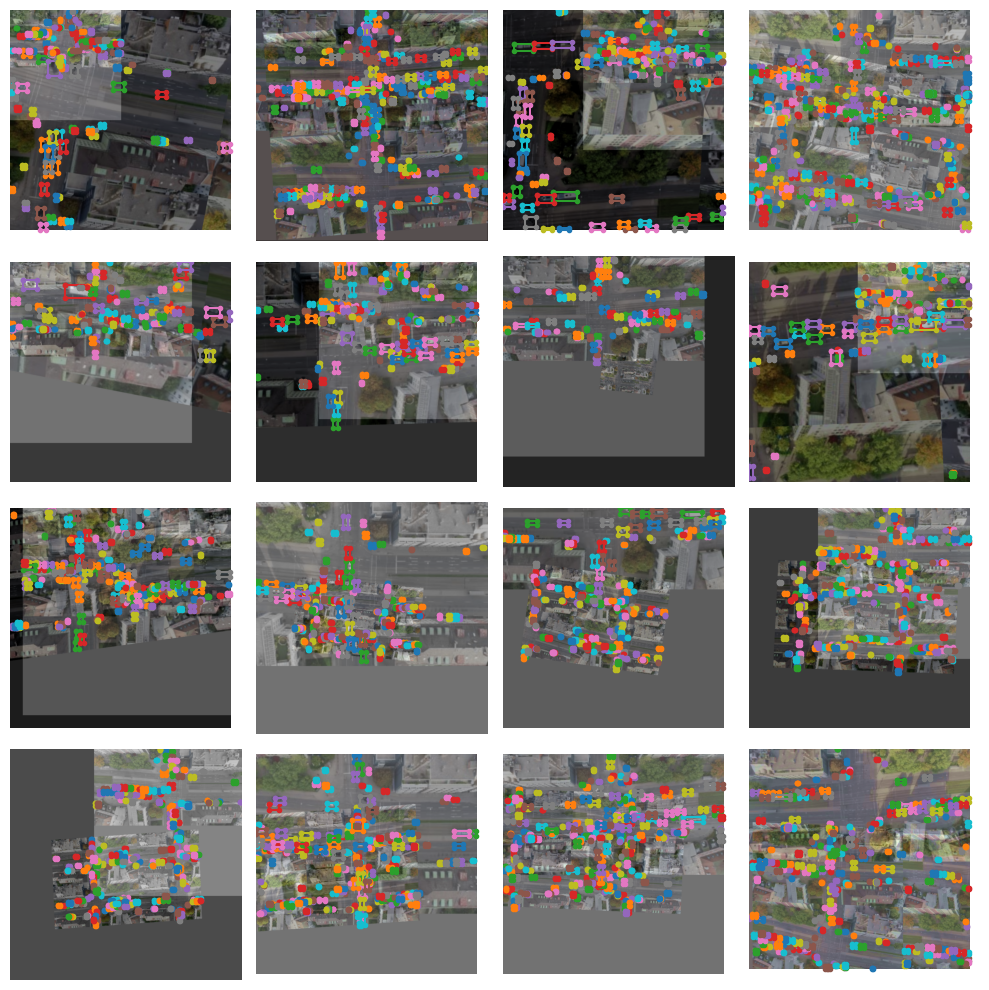

In [ ]:
train_data.dataset.plot()

# 👩🏽‍🦳 Instantiate the model

Below is how to instantiate the model for finetuning. Note you need to add the `num_classes` argument here.

Note, for this tutorial you're using `yolo_nas_l`, but SuperGradients has two other flavors of YOLONAS available to you: `yolo_nas_s` and `yolo_nas_m`.

In [ ]:
# creating new model
model = models.get(config.MODEL_NAME,
                   num_classes=config.NUM_CLASSES,
                   pretrained_weights=config.PRETRAINED_WEIGHTS
                   )

# 🖥️ Monitoring Training Using TensorBoard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir f"{config.CHECKPOINT_DIR}/{config.EXPERIMENT_NAME}"

# 🎛️ Training parameters

You need to define the training parameters for your training run.

Full details about the training parameters can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).


### 🚨 There are a few **mandatory** arguments that you must define for training params 🚨

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

You can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. If you choose to change the defualt parameters of these optimizrs you pass them into `optimizer_params`.

In [ ]:
train_params = {
    # ENABLING SILENT MODE
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 9,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# 🦾 Train the model

You've covered a lot of ground so far:

✅ Instantiated the trainer

✅ Defined your dataset parameters and dataloaders

✅ Instantiated a model

✅ Set up your training parameters

### ⏳ Now, its time to train a model

Training a model using a SuperGradients is done using the `trainer`.

It's as easy as..

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

The console stream is now moved to /content/drive/MyDrive/AP/checkpoints/first_video_yolonas_run/console_Oct16_18_10_28.txt


[2023-10-16 18:10:29] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-10-16 18:10:33] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 9925       (len(train_set))
    - Batch size per GPU:           4          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             4          (num_gpus * batch_size)
    - Effective Batch size:         4          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         2481       (len(train_loader))
    - Gradient updates per epoch:   2481       (len(train_loader) / batch_accumulate)

[2023-10-16 18:10:33] INFO - sg_trainer.py - Started training for 9 epochs (0/8)

Validating: 100%|██████████| 310/310 [01:02<00:00,  4.93it/s]
[2023-10-16 18:27:05] INFO - base_sg_logger.py 

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5765
│   ├── Ppyoloeloss/loss_iou = 0.1726
│   ├── Ppyoloeloss/loss_dfl = 0.5603
│   └── Ppyoloeloss/loss = 1.2881
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5975
    ├── Ppyoloeloss/loss_iou = 0.1777
    ├── Ppyoloeloss/loss_dfl = 0.5409
    ├── Ppyoloeloss/loss = 1.3122
    ├── Precision@0.50 = 0.1536
    ├── Recall@0.50 = 0.6178
    ├── Map@0.50 = 0.5118
    └── F1@0.50 = 0.2276



Validating epoch 1: 100%|██████████| 310/310 [01:01<00:00,  5.03it/s]


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5966
│   │   ├── Epoch N-1      = 0.5765 (↗ 0.0201)
│   │   └── Best until now = 0.5765 (↗ 0.0201)
│   ├── Ppyoloeloss/loss_iou = 0.1845
│   │   ├── Epoch N-1      = 0.1726 (↗ 0.0119)
│   │   └── Best until now = 0.1726 (↗ 0.0119)
│   ├── Ppyoloeloss/loss_dfl = 0.5665
│   │   ├── Epoch N-1      = 0.5603 (↗ 0.0062)
│   │   └── Best until now = 0.5603 (↗ 0.0062)
│   └── Ppyoloeloss/loss = 1.3411
│       ├── Epoch N-1      = 1.2881 (↗ 0.053)
│       └── Best until now = 1.2881 (↗ 0.053)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6176
    │   ├── Epoch N-1      = 0.5975 (↗ 0.0201)
    │   └── Best until now = 0.5975 (↗ 0.0201)
    ├── Ppyoloeloss/loss_iou = 0.1841
    │   ├── Epoch N-1      = 0.1777 (↗ 0.0063)
    │   └── Best until now = 0.1777 (↗ 0.0063)
    ├── Ppyoloeloss/loss_dfl = 0.5428
    │   ├── Epoch N-1      = 0.5409 (↗ 0.002)
    │   └── Best until now = 0.5409 (↗ 0.002)
    ├── Ppyoloeloss/loss = 1.3492
    │ 

Validating epoch 2: 100%|██████████| 310/310 [01:01<00:00,  5.01it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6187
│   │   ├── Epoch N-1      = 0.5966 (↗ 0.0221)
│   │   └── Best until now = 0.5765 (↗ 0.0422)
│   ├── Ppyoloeloss/loss_iou = 0.1966
│   │   ├── Epoch N-1      = 0.1845 (↗ 0.0121)
│   │   └── Best until now = 0.1726 (↗ 0.024)
│   ├── Ppyoloeloss/loss_dfl = 0.5745
│   │   ├── Epoch N-1      = 0.5665 (↗ 0.008)
│   │   └── Best until now = 0.5603 (↗ 0.0142)
│   └── Ppyoloeloss/loss = 1.3974
│       ├── Epoch N-1      = 1.3411 (↗ 0.0564)
│       └── Best until now = 1.2881 (↗ 0.1093)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6248
    │   ├── Epoch N-1      = 0.6176 (↗ 0.0073)
    │   └── Best until now = 0.5975 (↗ 0.0274)
    ├── Ppyoloeloss/loss_iou = 0.1912
    │   ├── Epoch N-1      = 0.1841 (↗ 0.0071)
    │   └── Best until now = 0.1777 (↗ 0.0135)
    ├── Ppyoloeloss/loss_dfl = 0.5464
    │   ├── Epoch N-1      = 0.5428 (↗ 0.0036)
    │   └── Best until now = 0.5409 (↗ 0.0055)
    ├── Ppyoloeloss/loss = 1.376
    │

Validating epoch 3: 100%|██████████| 310/310 [01:02<00:00,  4.98it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.632
│   │   ├── Epoch N-1      = 0.6187 (↗ 0.0133)
│   │   └── Best until now = 0.5765 (↗ 0.0555)
│   ├── Ppyoloeloss/loss_iou = 0.2045
│   │   ├── Epoch N-1      = 0.1966 (↗ 0.0079)
│   │   └── Best until now = 0.1726 (↗ 0.0319)
│   ├── Ppyoloeloss/loss_dfl = 0.5793
│   │   ├── Epoch N-1      = 0.5745 (↗ 0.0049)
│   │   └── Best until now = 0.5603 (↗ 0.0191)
│   └── Ppyoloeloss/loss = 1.4329
│       ├── Epoch N-1      = 1.3974 (↗ 0.0355)
│       └── Best until now = 1.2881 (↗ 0.1448)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6635
    │   ├── Epoch N-1      = 0.6248 (↗ 0.0386)
    │   └── Best until now = 0.5975 (↗ 0.066)
    ├── Ppyoloeloss/loss_iou = 0.1904
    │   ├── Epoch N-1      = 0.1912 (↘ -0.0008)
    │   └── Best until now = 0.1777 (↗ 0.0127)
    ├── Ppyoloeloss/loss_dfl = 0.5464
    │   ├── Epoch N-1      = 0.5464 (↗ 0.0)
    │   └── Best until now = 0.5409 (↗ 0.0056)
    ├── Ppyoloeloss/loss = 1.4128
    │ 

Validating epoch 4: 100%|██████████| 310/310 [01:04<00:00,  4.84it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6236
│   │   ├── Epoch N-1      = 0.632  (↘ -0.0084)
│   │   └── Best until now = 0.5765 (↗ 0.0471)
│   ├── Ppyoloeloss/loss_iou = 0.1996
│   │   ├── Epoch N-1      = 0.2045 (↘ -0.0049)
│   │   └── Best until now = 0.1726 (↗ 0.027)
│   ├── Ppyoloeloss/loss_dfl = 0.5767
│   │   ├── Epoch N-1      = 0.5793 (↘ -0.0026)
│   │   └── Best until now = 0.5603 (↗ 0.0164)
│   └── Ppyoloeloss/loss = 1.411
│       ├── Epoch N-1      = 1.4329 (↘ -0.0219)
│       └── Best until now = 1.2881 (↗ 0.1229)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6583
    │   ├── Epoch N-1      = 0.6635 (↘ -0.0051)
    │   └── Best until now = 0.5975 (↗ 0.0609)
    ├── Ppyoloeloss/loss_iou = 0.1943
    │   ├── Epoch N-1      = 0.1904 (↗ 0.0039)
    │   └── Best until now = 0.1777 (↗ 0.0165)
    ├── Ppyoloeloss/loss_dfl = 0.5473
    │   ├── Epoch N-1      = 0.5464 (↗ 0.0008)
    │   └── Best until now = 0.5409 (↗ 0.0064)
    ├── Ppyoloeloss/loss = 1.4177

Validating epoch 5: 100%|██████████| 310/310 [01:01<00:00,  5.05it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6108
│   │   ├── Epoch N-1      = 0.6236 (↘ -0.0127)
│   │   └── Best until now = 0.5765 (↗ 0.0344)
│   ├── Ppyoloeloss/loss_iou = 0.1931
│   │   ├── Epoch N-1      = 0.1996 (↘ -0.0065)
│   │   └── Best until now = 0.1726 (↗ 0.0205)
│   ├── Ppyoloeloss/loss_dfl = 0.5719
│   │   ├── Epoch N-1      = 0.5767 (↘ -0.0048)
│   │   └── Best until now = 0.5603 (↗ 0.0116)
│   └── Ppyoloeloss/loss = 1.3795
│       ├── Epoch N-1      = 1.411  (↘ -0.0315)
│       └── Best until now = 1.2881 (↗ 0.0915)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6531
    │   ├── Epoch N-1      = 0.6583 (↘ -0.0053)
    │   └── Best until now = 0.5975 (↗ 0.0556)
    ├── Ppyoloeloss/loss_iou = 0.1936
    │   ├── Epoch N-1      = 0.1943 (↘ -0.0007)
    │   └── Best until now = 0.1777 (↗ 0.0159)
    ├── Ppyoloeloss/loss_dfl = 0.5478
    │   ├── Epoch N-1      = 0.5473 (↗ 0.0005)
    │   └── Best until now = 0.5409 (↗ 0.0069)
    ├── Ppyoloeloss/loss = 1.4

Validating epoch 6: 100%|██████████| 310/310 [01:04<00:00,  4.79it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5954
│   │   ├── Epoch N-1      = 0.6108 (↘ -0.0155)
│   │   └── Best until now = 0.5765 (↗ 0.0189)
│   ├── Ppyoloeloss/loss_iou = 0.1846
│   │   ├── Epoch N-1      = 0.1931 (↘ -0.0085)
│   │   └── Best until now = 0.1726 (↗ 0.012)
│   ├── Ppyoloeloss/loss_dfl = 0.5669
│   │   ├── Epoch N-1      = 0.5719 (↘ -0.005)
│   │   └── Best until now = 0.5603 (↗ 0.0066)
│   └── Ppyoloeloss/loss = 1.3403
│       ├── Epoch N-1      = 1.3795 (↘ -0.0393)
│       └── Best until now = 1.2881 (↗ 0.0522)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6288
    │   ├── Epoch N-1      = 0.6531 (↘ -0.0243)
    │   └── Best until now = 0.5975 (↗ 0.0313)
    ├── Ppyoloeloss/loss_iou = 0.1832
    │   ├── Epoch N-1      = 0.1936 (↘ -0.0104)
    │   └── Best until now = 0.1777 (↗ 0.0055)
    ├── Ppyoloeloss/loss_dfl = 0.5432
    │   ├── Epoch N-1      = 0.5478 (↘ -0.0046)
    │   └── Best until now = 0.5409 (↗ 0.0023)
    ├── Ppyoloeloss/loss = 1.35

Validating epoch 7: 100%|██████████| 310/310 [01:05<00:00,  4.74it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5809
│   │   ├── Epoch N-1      = 0.5954 (↘ -0.0145)
│   │   └── Best until now = 0.5765 (↗ 0.0044)
│   ├── Ppyoloeloss/loss_iou = 0.1763
│   │   ├── Epoch N-1      = 0.1846 (↘ -0.0083)
│   │   └── Best until now = 0.1726 (↗ 0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.562
│   │   ├── Epoch N-1      = 0.5669 (↘ -0.0049)
│   │   └── Best until now = 0.5603 (↗ 0.0017)
│   └── Ppyoloeloss/loss = 1.3025
│       ├── Epoch N-1      = 1.3403 (↘ -0.0377)
│       └── Best until now = 1.2881 (↗ 0.0144)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6046
    │   ├── Epoch N-1      = 0.6288 (↘ -0.0241)
    │   └── Best until now = 0.5975 (↗ 0.0072)
    ├── Ppyoloeloss/loss_iou = 0.1822
    │   ├── Epoch N-1      = 0.1832 (↘ -0.001)
    │   └── Best until now = 0.1777 (↗ 0.0044)
    ├── Ppyoloeloss/loss_dfl = 0.5422
    │   ├── Epoch N-1      = 0.5432 (↘ -0.001)
    │   └── Best until now = 0.5409 (↗ 0.0014)
    ├── Ppyoloeloss/loss = 1.331

Validating epoch 8: 100%|██████████| 310/310 [01:01<00:00,  5.05it/s]
[2023-10-16 20:39:56] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/AP/checkpoints/first_video_yolonas_run/ckpt_best.pth
[2023-10-16 20:39:56] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5178208947181702


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5718
│   │   ├── Epoch N-1      = 0.5809 (↘ -0.0091)
│   │   └── Best until now = 0.5765 (↘ -0.0047)
│   ├── Ppyoloeloss/loss_iou = 0.1712
│   │   ├── Epoch N-1      = 0.1763 (↘ -0.0051)
│   │   └── Best until now = 0.1726 (↘ -0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.5589
│   │   ├── Epoch N-1      = 0.562  (↘ -0.0031)
│   │   └── Best until now = 0.5603 (↘ -0.0013)
│   └── Ppyoloeloss/loss = 1.2793
│       ├── Epoch N-1      = 1.3025 (↘ -0.0232)
│       └── Best until now = 1.2881 (↘ -0.0088)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5987
    │   ├── Epoch N-1      = 0.6046 (↘ -0.0059)
    │   └── Best until now = 0.5975 (↗ 0.0013)
    ├── Ppyoloeloss/loss_iou = 0.178
    │   ├── Epoch N-1      = 0.1822 (↘ -0.0042)
    │   └── Best until now = 0.1777 (↗ 0.0003)
    ├── Ppyoloeloss/loss_dfl = 0.5406
    │   ├── Epoch N-1      = 0.5422 (↘ -0.0017)
    │   └── Best until now = 0.5409 (↘ -0.0003)
    ├── Ppyoloeloss/loss 

[2023-10-16 20:40:06] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 9: 100%|██████████| 310/310 [01:11<00:00,  4.34it/s]


# 🏆 Get the best trained model

Now that training is complete, you need to get the best trained model.

You used checkpoint averaging so the following code will use weights averaged across training runs.

If you want to use the best weights, or weights from the last epoch you'd use one of the following in the code below:

- best weights: `checkpoint_path = os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, ckpt_best.pth)`

- last weights: `checkpoint_path = os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, ckpt_latest.pth)`

In [ ]:
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, 'average_model.pth'))

[2023-10-17 14:13:46] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/AP/checkpoints/first_video_yolonas_run/average_model.pth EMA checkpoint.


# 🧐 Evaluating the best trained model on the test set

In [ ]:
trainer.test(model=model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=config.NUM_CLASSES,
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,                                                                              nms_threshold=0.7)
                                                  ))

Testing:   0%|          | 0/310 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Testing: 100%|██████████| 310/310 [01:33<00:00,  3.30it/s]


{'PPYoloELoss/loss_cls': 0.59682775,
 'PPYoloELoss/loss_iou': 0.17784446,
 'PPYoloELoss/loss_dfl': 0.54087365,
 'PPYoloELoss/loss': 1.3118769,
 'Precision@0.50': 0.1535111516714096,
 'Recall@0.50': 0.6187072992324829,
 'mAP@0.50': 0.5151132941246033,
 'F1@0.50': 0.22800512611865997}

# 🔮 Predicting with the best model

You can make a prediction by calling the `.predict()` method of the model object.

Note, you can set the confidence threshold value as you please.


[2023-10-17 19:56:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


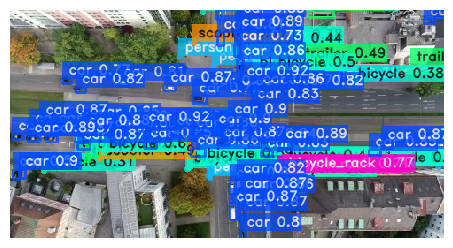

In [ ]:
model.predict( "/content/test/images/frame_10014.jpg",  conf=0.25).show()

In [ ]:
# our own BBox plotting function

import cv2
from google.colab.patches import cv2_imshow

bboxes = [[ 75.77515  , 150.14462  ,  90.90223  , 158.05588  ],
       [111.50534  , 125.69776  , 126.6539   , 133.49174  ],
       [136.21767  , 139.3097   , 151.52025  , 147.52943  ],
       [260.75156  ,  78.50842  , 274.75464  ,  90.20773  ],
       [111.48769  , 144.64098  , 126.7036   , 152.53137  ],
       [ 20.420536 , 120.57754  ,  35.94246  , 127.76917  ]]

colors_rgb = [
    (255, 0, 0),     # Red
    (0, 255, 0),     # Green
    (0, 0, 255),     # Blue
    (255, 255, 0),   # Yellow
    (0, 255, 255),   # Cyan
    (255, 0, 255),   # Magenta
    (128, 0, 0),     # Maroon
    (0, 128, 0),     # Green (128, 255, 0) is also a common choice
    (0, 0, 128),     # Navy
    (128, 128, 0),   # Olive
    (0, 128, 128),   # Teal
    (128, 0, 128),   # Purple
    (0 , 0, 0),      # black
]

def drawBBOX(p, img_url):
  bboxes, labels = p[0].prediction.bboxes_xyxy, p[0].prediction.labels,
  img = cv2.imread(img_url)

  for bbox, label in zip(bboxes, labels):
    img = cv2.rectangle(img, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), colors_rgb[int(label)], 1)

  cv2_imshow(img)

[2023-10-17 19:57:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


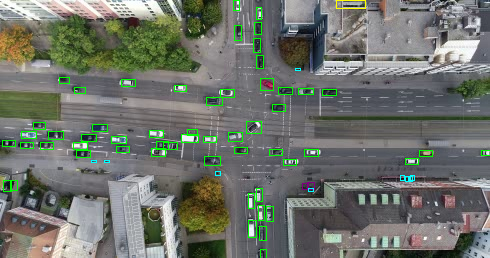

In [ ]:
from super_gradients.training.utils.predict.prediction_results import ImageDetectionPrediction
img_url = '/content/test/images/frame_10014.jpg'
p = model.predict(img_url)
drawBBOX(p, img_url)

[2023-10-17 19:57:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


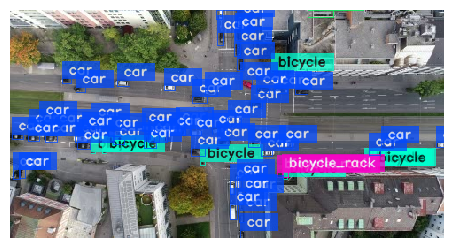

In [ ]:
model.predict(img_url).show(box_thickness=1, show_confidence=False)

In [ ]:
# predicting on a video
model.predict("/content/drive/MyDrive/AP/DJI_0780.MP4").save("/content/drive/MyDrive/APdetections.mp4")

Predicting Video: 100%|██████████| 266/266 [14:48<00:00,  3.34s/it]


# 🔭 Object Detection and Tracking

In [1]:
# clone DeepSORT repo
!git clone https://github.com/sujanshresstha/YOLO-NAS_DeepSORT.git

Cloning into 'YOLO-NAS_DeepSORT'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 36 (delta 14), reused 31 (delta 10), pack-reused 0
Receiving objects: 100% (36/36), 14.36 MiB | 14.72 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [45]:
import os
import numpy as np
import datetime
import cv2
import torch
from absl import app, flags, logging
from absl.flags import FLAGS
from deep_sort_realtime.deepsort_tracker import DeepSort
from super_gradients.training import models
from super_gradients.common.object_names import Models
from google.colab.patches import cv2_imshow

def track(video_flag, output_flag, model_flag="yolo_nas_s", conf_flag=0.5, class_id_flag=None):

    # set path to where you store your model
    model_path = "/content/drive/MyDrive/AP/checkpoints/first_video_yolonas_run/average_model.pth"

    # Load the COCO class labels the YOLO model was trained on
    classes_path = "/content/drive/MyDrive/AP/ap.class_names"

    # Initialize the video capture and the video writer objects
    video_cap = cv2.VideoCapture(video_flag)

    # frame_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    # frame_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    # fps = int(video_cap.get(cv2.CAP_PROP_FPS))
    fps=25
    width = 4096
    height = 2160
    scale_percent = 20 # percent of original size
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    dim = (width, height)

    # Initialize the video writer object
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    writer = cv2.VideoWriter(output_flag, fourcc, fps, (width, height))

    # Initialize the DeepSort tracker
    tracker = DeepSort(max_age=50)

    # Check if GPU is available, otherwise use CPU
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

    # Load the YOLO model
    model = models.get(model_flag, num_classes=13, checkpoint_path=os.path.join(model_path)).to(device)


    with open(classes_path, "r") as f:
        class_names = f.read().strip().split("\n")

    # Create a list of random colors to represent each class
    np.random.seed(42)  # to get the same colors
    colors = np.random.randint(0, 255, size=(len(class_names), 3))  # (80, 3)

    while True:
        # Start time to compute the FPS
        start = datetime.datetime.now()

        # Read a frame from the video
        ret, frame = video_cap.read()

        # If there is no frame, we have reached the end of the video
        if not ret:
            print("End of the video file...")
            break

        # resize the frame
        if frame is None:
          break
        # print(frame.shape)

        frame = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)

        # Run the YOLO model on the frame

        # Perform object detection using the YOLO model on the current frame
        detect = next(iter(model.predict(frame, iou=0.5, conf=conf_flag)))

        # Extract the bounding box coordinates, confidence scores, and class labels from the detection results
        bboxes_xyxy = torch.from_numpy(detect.prediction.bboxes_xyxy).tolist()
        confidence = torch.from_numpy(detect.prediction.confidence).tolist()
        labels = torch.from_numpy(detect.prediction.labels).tolist()
        # Combine the bounding box coordinates and confidence scores into a single list
        concate = [sublist + [element] for sublist, element in zip(bboxes_xyxy, confidence)]
        # Combine the concatenated list with the class labels into a final prediction list
        final_prediction = [sublist + [element] for sublist, element in zip(concate, labels)]

        # Initialize the list of bounding boxes and confidences
        results = []

        # Loop over the detections
        for data in final_prediction:
            # Extract the confidence (i.e., probability) associated with the detection
            confidence = data[4]

            # Filter out weak detections by ensuring the confidence is greater than the minimum confidence and with the class_id
            if class_id_flag == None:
                if float(confidence) < conf_flag:
                    continue
            else:
                if ((int(data[5] != class_id_flag)) or (float(confidence) < conf_flag)):
                    continue

            # If the confidence is greater than the minimum confidence, draw the bounding box on the frame
            xmin, ymin, xmax, ymax = int(data[0]), int(data[1]), int(data[2]), int(data[3])
            class_id = int(data[5])

            # Add the bounding box (x, y, w, h), confidence, and class ID to the results list
            results.append([[xmin, ymin, xmax - xmin, ymax - ymin], confidence, class_id])

        # Update the tracker with the new detections
        tracks = tracker.update_tracks(results, frame=frame)

        # Loop over the tracks
        for track in tracks:
            # If the track is not confirmed, ignore it
            if not track.is_confirmed():
                continue

            # Get the track ID and the bounding box
            track_id = track.track_id
            ltrb = track.to_ltrb()
            class_id = track.get_det_class()
            x1, y1, x2, y2 = int(ltrb[0]), int(ltrb[1]), int(ltrb[2]), int(ltrb[3])

            # Get the color for the class
            color = colors[class_id]
            B, G, R = int(color[0]), int(color[1]), int(color[2])

            # Create text for track ID and class name
            text = str(track_id) + " - " + str(class_names[class_id])

            # Draw bounding box and text on the frame
            cv2.rectangle(frame, (x1, y1), (x2, y2), (B, G, R), 2)
            cv2.rectangle(frame, (x1 - 1, y1 - 20), (x1 + len(text) * 5, y1), (B, G, R), -1)
            cv2.putText(frame, text, (x1 + 5, y1 - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.2, (255, 255, 255), 1)

        # End time to compute the FPS
        end = datetime.datetime.now()

        # Show the time it took to process 1 frame
        print(f"Time to process 1 frame: {(end - start).total_seconds() * 1000:.0f} milliseconds")

        # Show the frame
        # cv2_imshow(frame)

        # Write the frame to the output video file
        writer.write(frame)

        # Check for 'q' key press to exit the loop
        if cv2.waitKey(1) == ord("q"):
            break

    # Release video capture and video writer objects
    video_cap.release()
    writer.release()

    # Close all windows
    cv2.destroyAllWindows()

In [ ]:
# Detect and Track on your video
track(video_flag="/content/drive/MyDrive/AP/DJI_0780.MP4", output_flag= "/content/drive/MyDrive/AP/ap_output.mp4", conf_flag=0.6 )